# Анализ системы метрик приложения

Я — продуктовый аналитик приложения Procrastinate Pro+, которое предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

Мои задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

В моем распоряжении есть данные о посещениях приложения, покупках и расходах на маркетинг.
Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных

Загрузим данные и получим основную информацию о них. Проведем необходимую предобработку. Основную информацию о данных и предобработке зафиксируем в кратком промежуточном выводе.

In [1]:
# загрузка необходимых библиотек
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import math
import matplotlib.colors as mcolors


In [ ]:
# загрузка таблиц в переменные
df_visits = pd.read_csv('', sep=',')
df_orders = pd.read_csv('')
df_costs = pd.read_csv('')

In [3]:
# функция отображения информации
def info(dataframe):
    display(dataframe.head(5))
    display(dataframe.info())

In [4]:
# отображение информации
info(df_visits)
info(df_orders)
info(df_costs)

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        161865 non-null  int64 
 1   region         161865 non-null  object
 2   device         161865 non-null  object
 3   channel        161865 non-null  object
 4   session_start  161865 non-null  object
 5   session_end    161865 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.4+ MB


None

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   33893 non-null  int64  
 1   event_dt  33893 non-null  object 
 2   revenue   33893 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 794.5+ KB


None

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       976 non-null    object 
 1   channel  976 non-null    object 
 2   costs    976 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.0+ KB


None

Датасет `ppro_visits.csv` содержит 6 столбцов и 161865 строк.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов приведены к одному виду snake case.
- **Числовые значения (int64).** один столбец, `user_id `. Представлен верный тип данных, так как эт индикатор.
- **Строковые данные (object).** 5  столбцов имеют тип данных `object`:
    - `region`, `device`, `channel` содержат строковую информацию, что логично для текстовых данных. Здесь тип данных `object` подходит.
    - `session_start`, `session_end` хранят информацию о дате, не корректный тип, стоит привести к типу даты
- Пропусков нет. 
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

Датасет `ppro_orders.csv` содержит 3 столбца и 33893 строк.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов приведены к одному виду snake case.
- **Числовые значения (int64).** один столбец, `user_id`. Представлен верный тип данных, так как эт индикатор.
- **Строковые данные (object).** 1  столбец имеют тип данных `object`:
    - `event_dt` хранит информацию о дате, не корректный тип, стоит привести к типу даты
- **Числовое значение с плавающей запятой (float64).** 1  столбец имеют тип данных `object`:
    - `revenue` хранит информацию о выручке, корректный тип, так как число не всегда может получаться целым
- Пропусков нет. 
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

Датасет `ppro_costs.csv` содержит 3 столбца и 976 строк.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов приведены к одному виду snake case.
- **Строковые данные (object).** 2  столбцоа имеют тип данных `object`:
    - `channel` содержит строковую информацию, что логично для текстовых данных. Здесь тип данных `object` подходит.
    - `dt` хранит информацию о дате, не корректный тип, стоит привести к типу даты
- **Числовое значение с плавающей запятой (float64).** 1  столбец имеют тип данных `object`:
    - `costs` хранит информацию о затратах на рекламу, корректный тип, так как число не всегда может получаться целым
- Пропусков нет. 
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

Проверим данные  на дубликаты

In [5]:
drop = df_visits.duplicated().sum()
drop

0

In [6]:
drop = df_orders.duplicated().sum()
drop

0

In [7]:
drop = df_costs.duplicated().sum()
drop

0

Дубликатов   обнаружено не было

Изменим тип данных необходимым столбцам

In [8]:
df_visits['session_start'] = pd.to_datetime(df_visits['session_start'])
df_visits['session_end'] = pd.to_datetime(df_visits['session_end'])
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt'])
df_costs['dt'] = pd.to_datetime(df_costs['dt'])

Проверим, что изменения применились

In [9]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  object        
 2   device         161865 non-null  object        
 3   channel        161865 non-null  object        
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 7.4+ MB


In [10]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 794.5 KB


In [11]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       976 non-null    datetime64[ns]
 1   channel  976 non-null    object        
 2   costs    976 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.0+ KB


После обработки данных, можно сказать:
- во всех данных отсутствуют дубликаты,
- типы данных были корректно изменены

## Подготовка данных к когортному анализу

Подготовим данные к когортному анализу с учётом того, что мы будете изучать окупаемость привлечения пользователей за первые 28 дней.

Для каждого пользователя найдем:
- дату первой сессии (дата привлечения пользователя, `first_dt`);
- канал привлечения (`first_channel`);
- стоимость привлечения пользователя (`cac`).

Результаты сохраним в новой таблице, например, `profiles`.

Добавим к данным с событиями и покупками информацию о первом источнике привлечения и дату привлечения пользователя из созданной таблицы. После этого рассчитаем дневной лайфтайм для каждого события или покупки и добавим в таблицу в виде целого числа. В дальнейшем при проведении когортного анализа используем информацию о первом источнике привлечения пользователя.

Создадим таблицу profiles, в которую далее будем сохранять  все результаты.

Найдем дату первой сессии и канал привлечения

In [12]:
#Упорядочим по дате сессии для последующего корректного поиска даты первой сессии
profiles = df_visits.sort_values(by ='session_start')
# Для каждого пользователя найдем дату первой сессии
profiles['first_dt'] = profiles.groupby('user_id')['session_start'].transform(min)
# Для каждого пользователя найдем канал привлечения, актуальный для первой сессии 
profiles['first_channel'] = profiles.apply(lambda x: x['channel'] if (x['session_start']== x['first_dt']) else 0, axis=1)
# Оставим только требуемые столбцы, относящиеся к первой сессии
profiles = profiles[profiles['first_channel']!=0][['user_id','first_dt', 'first_channel']]


In [13]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74856 entries, 297 to 161570
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        74856 non-null  int64         
 1   first_dt       74856 non-null  datetime64[ns]
 2   first_channel  74856 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.3+ MB


Посчитаем стоимость привлечения пользователя

In [14]:
#Округлим  first_dt и dt
profiles['first_dt'] = profiles['first_dt'].dt.date
df_costs['dt'] = df_costs['dt'].dt.date
# Новые пользователи по дате и каналу
new_users = profiles.groupby(['first_dt', 'first_channel']).agg(new_users=('user_id','nunique')).reset_index()
# Объединяем
cac_data = new_users.merge(df_costs, left_on=['first_dt', 'first_channel'], right_on=['dt', 'channel'], how='left')
# CAC
cac_data['cac'] = cac_data['costs'] / cac_data['new_users']
# Оставляем только необходимые столбцы
cac_data = cac_data[['first_dt', 'first_channel', 'cac']]
# Добавляем CAC в  profiles
profiles = profiles.merge(cac_data, on=['first_dt', 'first_channel'], how='left')

profiles.head()

,user_id,first_dt,first_channel,cac
0,767410614400,2024-04-01,MediaTornado,0.249160
1,641772204272,2024-04-01,MediaTornado,0.249160
2,934895210751,2024-04-01,RocketSuperAds,0.886429
3,226472994774,2024-04-01,FaceBoom,0.939390
4,686701513307,2024-04-01,MediaTornado,0.249160


Расчитаем лайфтайм, будем высчитывать через покупки и события, то есть с таблицами df_orders и profiles, df_visits и profiles

In [15]:
# Приводим даты к datetime
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt'])
profiles['first_dt'] = pd.to_datetime(profiles['first_dt'])
df_visits['session_start'] = pd.to_datetime(df_visits['session_start'])
# Объединяем
df_orders = df_orders.merge(profiles[['user_id', 'first_dt', 'first_channel']], on='user_id', how='left')
df_visits = df_visits.merge(profiles[['user_id', 'first_dt', 'first_channel']], on='user_id', how='left')
# Лайфтайм в днях
df_orders['lifetime_day'] = (df_orders['event_dt'] - df_orders['first_dt']).dt.days
df_visits['lifetime_day'] = (df_visits['session_start'] - df_visits['first_dt']).dt.days

df_orders.head(20)


,user_id,event_dt,revenue,first_dt,first_channel,lifetime_day
0,771951256319,2024-04-01 05:56:26,2.99,2024-04-01,FaceBoom,0
1,829942381059,2024-04-01 14:55:02,2.99,2024-04-01,FaceBoom,0
2,727879856738,2024-04-01 22:15:09,14.99,2024-04-01,FaceBoom,0
3,481270888930,2024-04-01 06:05:14,2.99,2024-04-01,TipTop,0
4,844695029762,2024-04-01 01:19:52,2.99,2024-04-01,FaceBoom,0
5,601982992004,2024-04-01 19:02:56,2.99,2024-04-01,MediaTornado,0
6,373037757367,2024-04-01 21:48:58,2.99,2024-04-01,FaceBoom,0
7,588009939701,2024-04-01 06:32:32,4.49,2024-04-01,TipTop,0
8,550254063862,2024-04-01 18:53:41,4.49,2024-04-01,TipTop,0
9,328482322349,2024-04-01 04:47:07,2.99,2024-04-01,MediaTornado,0


In [16]:
df_visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel,lifetime_day
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00,2024-04-01,MediaTornado,0
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00,2024-04-01,RocketSuperAds,0
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00,2024-04-01,MediaTornado,0
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00,2024-04-01,MediaTornado,0
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00,2024-04-01,RocketSuperAds,0


Данные готовы для когортного анализа

## Анализ месячной динамики основных метрик продукта

**Задача 1**. Начнен анализ данных с изучения динамики активности пользователей и их вовлечённости в продукт. Рассчитаем по всем данным значения DAU, MAU и Stickiness и визуализируем их. Активными считаем всех пользователей, которые взаимодействовали с приложением.

**Задача 2**. В разрезе каждого месяца привлечения новых пользователей рассчитаем:
- Среднюю стоимость привлечения пользователя (CAC).
- Значение LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения.



Посчитаем метрики: количество уникальных пользователей в этот день,  количество уникальных пользователей в этот месяц и как часто пользователи возвращаются к продукту в рамках месяца.

In [17]:
# День и месяц сессии
df_visits['session_date'] = df_visits['session_start'].dt.date
df_visits['session_month'] = df_visits['session_start'].dt.to_period('M')
# DAU
df_visits['DAU'] = df_visits.groupby('session_date')['user_id'].transform('nunique')
# MAU
df_visits['MAU'] = df_visits.groupby('session_month')['user_id'].transform('nunique')
# Stickiness
df_visits['stickiness'] = df_visits['DAU'] / df_visits['MAU']

In [18]:
df_visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel,lifetime_day,session_date,session_month,DAU,MAU,stickiness
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00,2024-04-01,MediaTornado,0,2024-04-01,2024-04,356,9069,0.039255
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00,2024-04-01,RocketSuperAds,0,2024-04-01,2024-04,356,9069,0.039255
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00,2024-04-01,MediaTornado,0,2024-04-01,2024-04,356,9069,0.039255
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00,2024-04-01,MediaTornado,0,2024-04-01,2024-04,356,9069,0.039255
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00,2024-04-01,RocketSuperAds,0,2024-04-01,2024-04,356,9069,0.039255


Визуализируем значения, получившихся метрик также добавим скользящее среднее чтобы сгладить шум.

Визуализация метрики DAU.

In [19]:
daily = df_visits.drop_duplicates(['session_date']).copy()

# Скользящее среднее
daily['DAU_roll'] = daily['DAU'].rolling(window=7).mean()
daily['stickiness_roll'] = daily['stickiness'].rolling(window=7).mean()

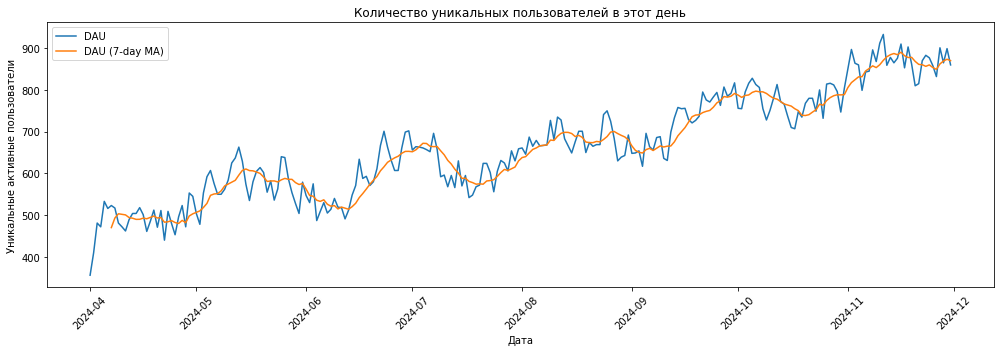

In [20]:
plt.figure(figsize=(14,5))
sns.lineplot(data=daily, x='session_date', y='DAU', label='DAU')
sns.lineplot(data=daily, x='session_date', y='DAU_roll', label='DAU (7-day MA)')
plt.title('Количество уникальных пользователей в этот день')
plt.xlabel('Дата')
plt.ylabel('Уникальные активные пользователи')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- DAU за весь период повышается.
- В начале апреля значения находятся около 350, а к ноябрю поднимаются до 900.
- Скользящее среднее подтверждает долгосрочный восходящий тренд.
- Присутствуют недельные сезонные колебания, что типично для пользовательской активности.
- Много пиков и спадов, однако каждый спад заканчивается последующим ростом

Визуализация метрики MAU.

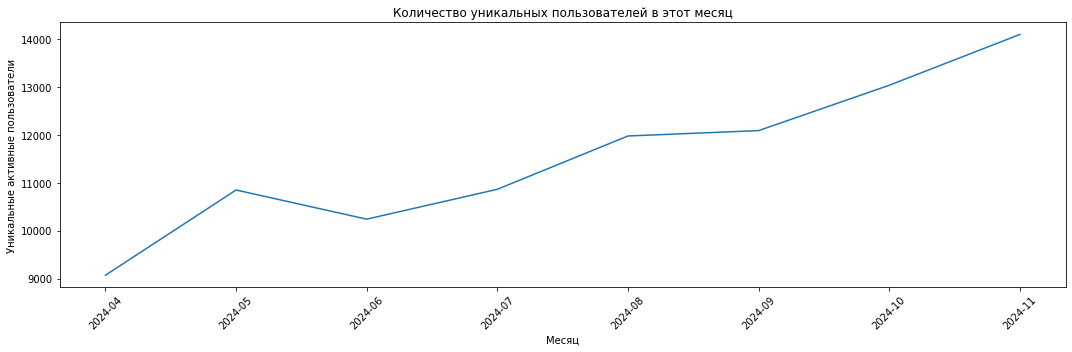

In [21]:
df_visits['session_month_str'] = df_visits['session_month'].astype(str)
plt.figure(figsize=(15,5))
sns.lineplot(
    data=df_visits.drop_duplicates(['session_month']), 
    x='session_month_str', 
    y='MAU'
)
plt.title('Количество уникальных пользователей в этот месяц')
plt.xlabel('Месяц')
plt.ylabel('Уникальные активные пользователи')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MAO показвает такие же результаты, как и DAO.
- значения практически постоянно растут и не опускаются ниже минимальной отметки в апреле.
- самое низкое значение было зафиксировано в апреле - примерно 9000, а самое высокое в ноябре, оно  достигает 14000.
- самое резкое паление наблюдается с мая по июнь, за месяц просадка примерно на 1000 человек, однако в дальнейшем наблюдается либо рост, либо стагнация с августа по сентябрь.

Визуализация метрики Stickiness.

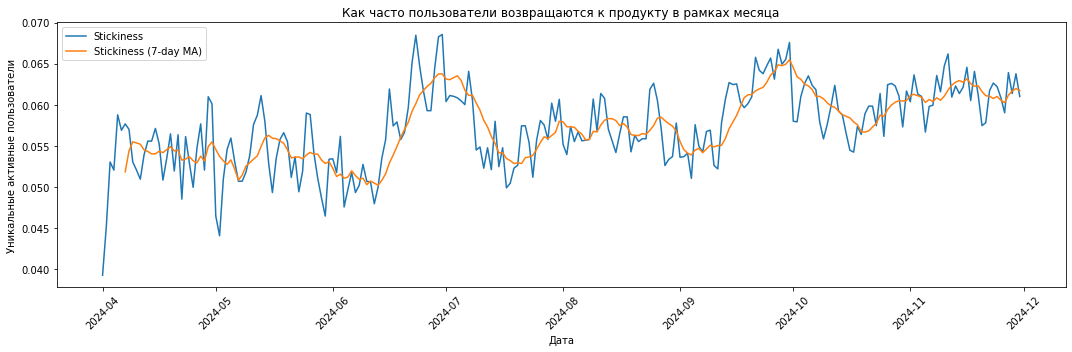

In [22]:
plt.figure(figsize=(15,5))
sns.lineplot(data=daily, x='session_date', y='stickiness', label='Stickiness')
sns.lineplot(data=daily, x='session_date', y='stickiness_roll', label='Stickiness (7-day MA)')
plt.title('Как часто пользователи возвращаются к продукту в рамках месяца')
plt.xlabel('Дата')
plt.ylabel('Уникальные активные пользователи')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Stickiness показывает аналогичные результаты.
- рост Stickiness менее выражен, чем предыдущие метрики, однако с течением года он не переступает отметки ниже минимальной в апреле (0.04), а к концу  года достигает отметки примерно в 0.065
- наблюдаются постоянные взлеты, но не такие сильные падения
- пиковое значение находится в конце июня - примерно 0.07
- стагнация наблюдается с конца июля по начало сентября, хотя во всех остальных месяцах до и после наблюдается падение раз в месяц и снова восхождение

Можно сказать, что поток людей практически постоянно идет в гору, однако в промежутке с мая по июнь наблюдается слишком резкое снижение, по сравнению с остальными месяцами, но, возможно, это связано с периудом ввода в эксплуатацию и привыканием пользователей к новому виду контента, та как с июня по июль мы видем наибольшее желание пользователей возвращаться в приложение. Можно заметить, что к концу года все больше новых пользователей, а так же тех, кто возвращается в приложение.

Рассчитаем среднюю стоимость привлечения пользователя.

In [23]:
# Месяц первой сессии
profiles['first_month'] = profiles['first_dt'].dt.to_period('M')
# Средний CAC по месяцу привлечения
cac_month = profiles.groupby('first_month')['cac'].mean().reset_index()

cac_month.head()

,first_month,cac
0,2024-04,0.734706
1,2024-05,0.748572
2,2024-06,0.973978
3,2024-07,1.054344
4,2024-08,1.155601


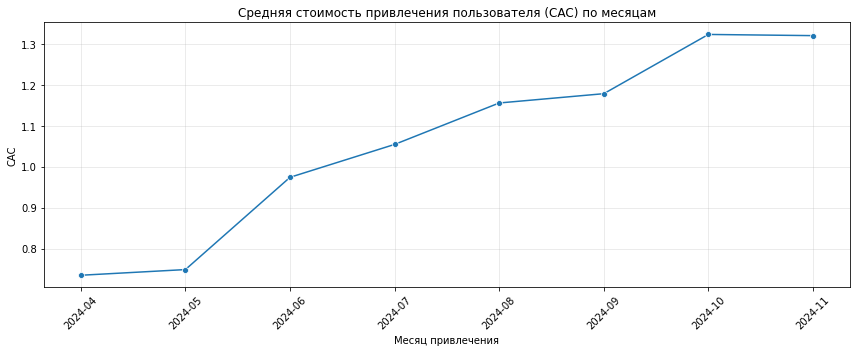

In [24]:
cac_plot = cac_month.copy()
cac_plot['first_month'] = cac_plot['first_month'].astype(str)

plt.figure(figsize=(12,5))
sns.lineplot(data=cac_plot, x='first_month', y='cac', marker='o')
plt.title('Средняя стоимость привлечения пользователя (CAC) по месяцам')
plt.xlabel('Месяц привлечения')
plt.ylabel('CAC')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Расходы на привлечение пользователей с начала и до конца периода выросли практически в 2 раза, с 0.7 до 1.3 . Причем с мая по июнь взлет виден наиболее ощутимо, за один месяц значение поднялось с 0.75 до практически 1, хотя в последующие месяцы затраты увеличивались примерно на одну единицу, это логично, так как запускался новый вид контента, пользователи должны были о нем узнать. Необходим большой приток новых платящих клиентов, что бы стоимость на привлечение окупилась.

Рассчитаем значение LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения.

In [43]:
# Группируем данные по месяцу, считаем средний САС
cac = profiles.copy()
# Выделяем первый месяц привлечения
cac['first_month'] = cac['first_dt'].dt.to_period('M').dt.to_timestamp()
# Группируем данные по месяцу, считаем средний САС
cac = cac.groupby(['first_month']).agg(
total_users = ('user_id','nunique'),
avg_cac = ('cac','mean'),
).reset_index()
# Оставляем покупки, совершенные в первые 28 дней
ltv = df_orders[df_orders['lifetime_day'] < 28].copy()
# Выделяем первый месяц привлечения
ltv['first_month'] = ltv['first_dt'].dt.to_period('M').dt.to_timestamp() 
# Считаем выручку с пользователей за каждый месяц (по месяцу привлечения)
ltv = ltv.groupby(['first_month']).agg(
revenue_28 = ('revenue','sum'),
).reset_index()
# Добавляем размер когорт и САС
ltv = ltv.merge(cac, on='first_month')
# Считаем LTV на 28 день
ltv['ltv_28'] = ltv['revenue_28'] / ltv['total_users']                                                                 
# Рассчитаем ROI за 28 дней:
ltv['roi_28'] = (ltv['ltv_28'] - ltv['avg_cac']) / ltv['avg_cac']

Визуализируем LTV линейным графиком

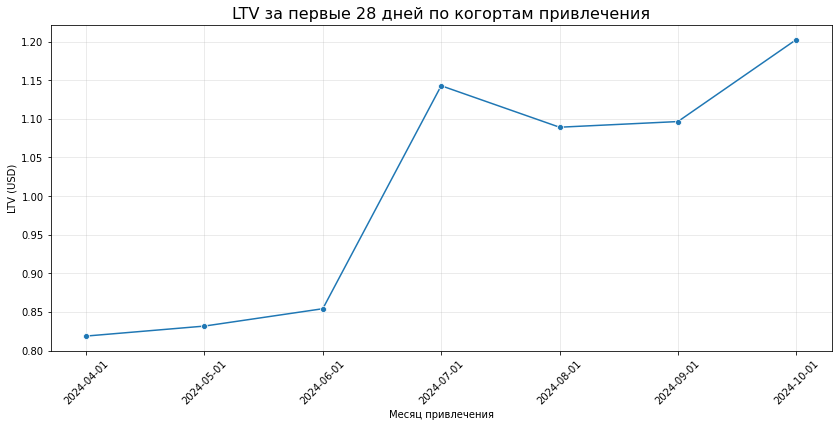

In [26]:
plot_df = ltv.copy()
# Исключаем неполную ноябрьскую когорту (2024-11)
plot_df = plot_df[plot_df['first_month'] != '2024-11-01']
plot_df['first_month_str'] = plot_df['first_month'].astype(str)

plt.figure(figsize=(14,6))
sns.lineplot(data=plot_df, x='first_month_str', y='ltv_28', marker='o')
plt.title('LTV за первые 28 дней по когортам привлечения', fontsize=16)
plt.xlabel('Месяц привлечения')
plt.ylabel('LTV (USD)')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()

LTV практически постоянно возрастает, это говорит о том, что прибыль от одного клиента растет. В начале года можно заметить, что график растет постепенно с 0.82 до 0.85, а с внедрением изменений уже в первый месяц достигает отметки в 1.15, в дальнейшем наблюдается легкая просадка, с последующим взлетом

Визуализируем ROI линейным графиком

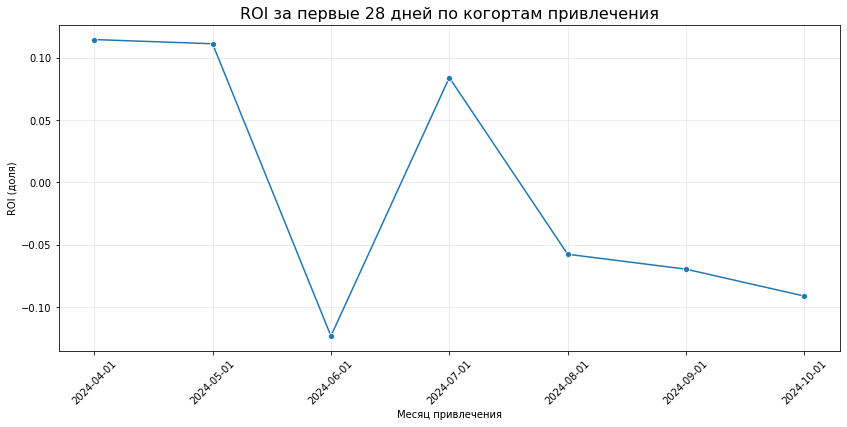

In [27]:
plt.figure(figsize=(14,6))
sns.lineplot(data=plot_df, x='first_month_str', y='roi_28', marker='o')
plt.title('ROI за первые 28 дней по когортам привлечения', fontsize=16)
plt.xlabel('Месяц привлечения')
plt.ylabel('ROI (доля)')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()

В отличие от LTV, картина  ROI не такая радужная, уже начиная с мая по юнь наблюдается существенная просадка с 0.11 до -0.12, возможно, маркетинг начинал работать уже с этого момента, потому что за первый месяц после внедрения новвовведения график возрос до значения, близкого первоначальному. Однако после яркого взлета с июля начинается постепенная просадка, которая к концу года достигает критической отметки в -0.9. Это плохой исход собятий, говорящий, что клиенты не приносят на столько много денег, чтобы окупаться, а инвестиции не были на столько успешными.

После запуска нового спортивного контента в начале лета наблюдается общая положительная динамика активности пользователей: DAU и MAU постепенно растут, Stickiness слегка увеличивается, хотя в период май–июнь был кратковременный спад, вероятно связанный с привыканием пользователей к новому контенту. Расходы на привлечение выросли почти вдвое, при этом качество трафика осталось высоким. LTV пользователей растёт, что показывает рост дохода с одного клиента, особенно после запуска нового спортивного контента. При этом ROI снижается начиная с июля и к концу года падает ниже окупаемости, что указывает на то, что рост затрат на маркетинг не компенсируется доходом от новых пользователей. Это говорит о необходимости оптимизации маркетинговых вложений и более тщательного таргетинга для новых когорт.

## Анализ метрик в разрезе источника привлечения

Теперь необходимо разобраться, какие источники привлечения перспективны, а какие за 28 дней не окупились.

**Задача 1**. Определим самые популярные источники привлечения:
- Посчитаем общее число привлечённых пользователей для каждого источника.
- Визуализируем динамику набора новых пользователей по дням в каждом источнике.
- Рассчитаем и визуализируем динамику DAU, MAU и Stickiness по источникам привлечения.

**Задача 2**. Изучим динамику изменения метрик на 28-й день в разрезе источника. Проведем анализ с выделением недельных когорт по дате привлечения. Рассчитаем и визуализируем:
- Скользящее удержание на 14-й день с момента привлечения (за период с 14-го по 28-й день).
- Конверсию в покупку.
- Недельную динамику затрат на маркетинг по каждому источнику привлечения.
- Динамику среднего CAC, значений LTV и ROI.


Посмотрим на число привлечённых пользователей по каналам

In [28]:
channel_users = profiles.groupby('first_channel')['user_id'].nunique().reset_index()
channel_users = channel_users.sort_values('user_id', ascending=False)

channel_users

,first_channel,user_id
0,FaceBoom,28401
3,TipTop,18118
2,RocketSuperAds,14257
1,MediaTornado,14080


Можно с уверенностью сказать, что FaceBoom вырвался в лидеры с большим отрывом, по сравнению со вторым местом (TipTop) разница в больше, чем 10000 человек, хотя у всех остальных каналов разница не такая  уж ощутимая: 177 и 3861 человек. Стоит явно обратить внимание на FaceBoom и больше смещать финансовый акцент на него, по крайней мере на первый взгляд.

Посмотрим нагляднее на динамику набора новых пользователей по дням в каждом источнике

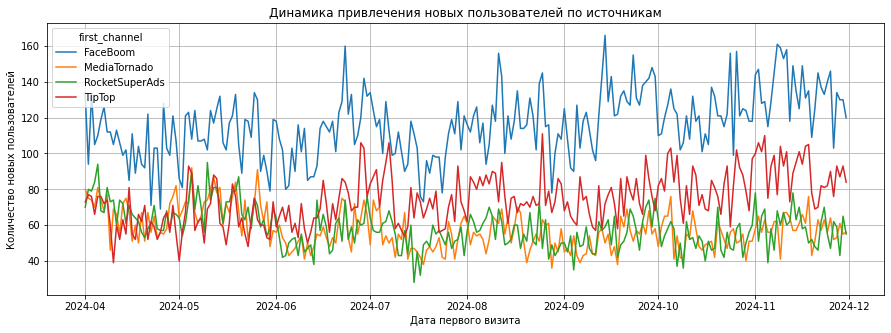

In [29]:
new_users_daily = profiles.groupby(['first_channel', 'first_dt'])['user_id'].nunique().reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=new_users_daily, x='first_dt', y='user_id', hue='first_channel')
plt.title('Динамика привлечения новых пользователей по источникам')
plt.xlabel('Дата первого визита')
plt.ylabel('Количество новых пользователей')
plt.legend(title='first_channel')
plt.grid(True)
plt.show()


FaceBoom всегда привлекал новых пользователей больше всех, это стабильный канал, в котором можно быть уверенным. Очень интересная ситуация с TipTop, до нововведений он был практически на равне с оставшимися двумя каналами, однакоко с июня количество новых пользователей, которых он привлекает сильно возросло, ранее его порог был примерно 90, но после значение может достигать 110. Однако, каналы RocketSuperAds и MediaTornado с июня месяца начали слегка терять новых пользователей, с мая по июнь они привлекали примерно 60-90 пользователей в месяц, а в июле достигли своего критического минимама в 30 пользователей, а в последующие месяцы не смогли выйти на начальный уровень, тем самым понизив планку до 40-70 пользователей в месяц.

Рассмотрим DAU по источникам привлечения.

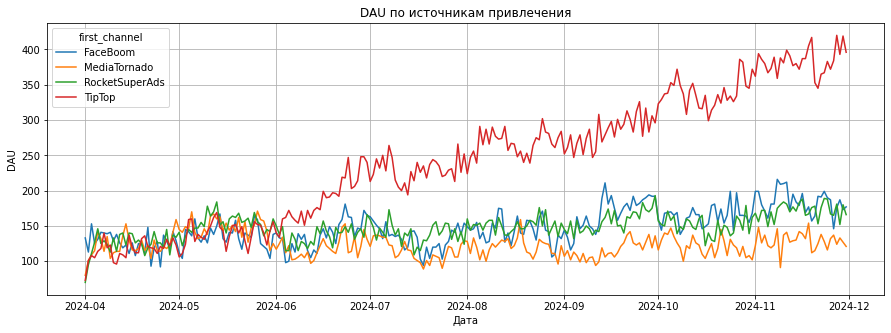

In [30]:
df_visits['date'] = df_visits['session_start'].dt.date
dau = df_visits.groupby(['date', 'first_channel'])['user_id'].nunique().reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=dau, x='date', y='user_id', hue='first_channel')
plt.title('DAU по источникам привлечения')
plt.xlabel('Дата')
plt.ylabel('DAU')
plt.grid(True)

plt.show()

Рассматривая колличество уникальных активных пользователей в день можно заметить, что все каналы держались примерно на равне, однако после нововведений  TipTop начал активно расти, а к концу года поднялся с отметки 150 до 400 пользователей в день, другие же каналы так и остались в пределах 100-200 пользователей в день

Рассмотрим MAU по источникам привлечения.

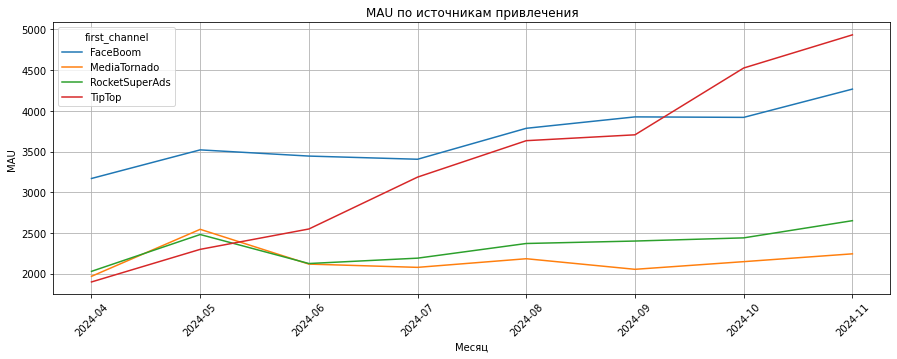

In [31]:
df_visits['month'] = df_visits['session_start'].dt.to_period('M')
mau = df_visits.groupby(['month', 'first_channel'])['user_id'].nunique().reset_index()
mau['month'] = mau['month'].astype(str)

plt.figure(figsize=(15, 5))
sns.lineplot(data=mau, x='month', y='user_id', hue='first_channel')
plt.title('MAU по источникам привлечения')
plt.xlabel('Месяц')
plt.ylabel('MAU')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


Рассматривая уникальных пользователей по месяцам, получается смешанная картина, канал FaceBoom, всегда имел высокую отметку, однако рос очень медленно. При этом TipTop после нововведений начал активно привлекать новых пользователей, а к середине сентября так же обогнал FaceBoom, к концу года он стал привлекать больше всего людей и достиг отметки с 2000 до 5000. Остальные же каналы имели, как взлеты, так и падения, поэтому их вклад рос не так сильно

Рассмотрим Stickiness по источникам привлечения.

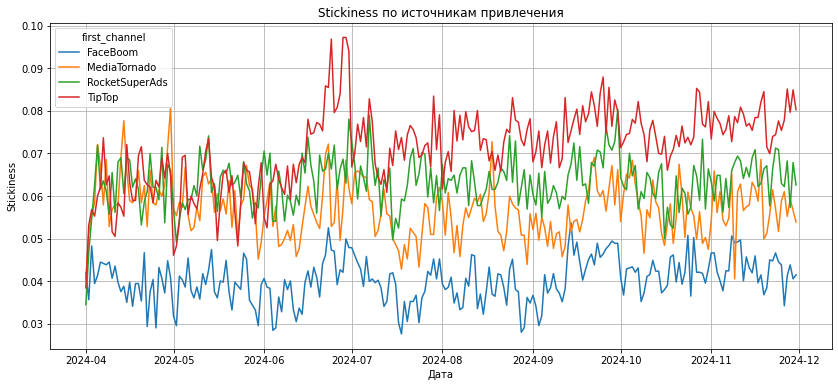

In [32]:
# Привяжем месяц к каждому дню в dau
dau['month'] = pd.to_datetime(dau['date']).dt.to_period('M').astype(str)
# Переименуем столбцы для объединения
dau.rename(columns={'user_id': 'DAU'}, inplace=True)
mau.rename(columns={'user_id': 'MAU'}, inplace=True)
stick = dau.merge(mau, on=['month', 'first_channel'], how='left')
stick['stickiness'] = stick['DAU'] / stick['MAU']

plt.figure(figsize=(14, 6))
sns.lineplot(data=stick, x='date', y='stickiness', hue='first_channel')
plt.title('Stickiness по источникам привлечения')
plt.xlabel('Дата')
plt.ylabel('Stickiness')
plt.grid(True)

plt.show()


Анализируя "Прилипательность" пользователей, бросается в глаза, что FaceBoom, хоть и сильно завлекал новую аудиторию, но удерживал хуже  всех. TipTop изначально был на равне с каналами RocketSuperAds и RocketSuperAds и имел довольно высокое удержание, но после нововведений он достигает своего пика в отметке 0.1, и, даже не смотря на то, что он слегка сбрасывает обороты, он все равно активнее всех удерживает пользователей до конца года.

Выделим недельные когорты по дате привлечения

In [33]:
# Недельная когорта по дате привлечения
profiles['first_week'] = profiles['first_dt'].dt.to_period('W').dt.to_timestamp()
df_visits['first_week'] = df_visits['first_dt'].dt.to_period('W').dt.to_timestamp()
df_orders['first_week'] = df_orders['first_dt'].dt.to_period('W').dt.to_timestamp()


Найдем скользящее удержание на 14-й день с момента привлечения (за период с 14-го по 28-й день).

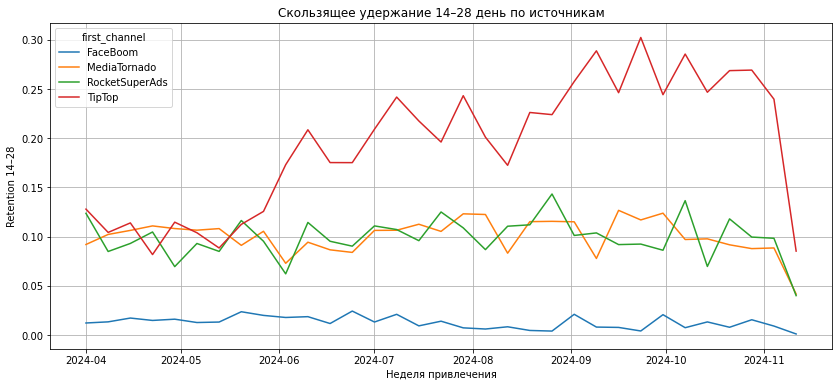

In [34]:
# События до 28 дня жизни
visits_28 = df_visits[df_visits['lifetime_day'] < 28]

# Размер когорт
cohort_size = visits_28[visits_28['lifetime_day'] == 0] \
    .groupby(['first_week', 'first_channel'])['user_id'] \
    .nunique().reset_index(name='cohort_size')

# Удержались до 14–28 дня
retained_14_28 = visits_28[visits_28['lifetime_day'] >= 14] \
    .groupby(['first_week', 'first_channel'])['user_id'] \
    .nunique().reset_index(name='retained')

retention = cohort_size.merge(retained_14_28, on=['first_week', 'first_channel'], how='left')
retention['retention_rate'] = retention['retained'] / retention['cohort_size']

plt.figure(figsize=(14, 6))
sns.lineplot(data=retention, x='first_week', y='retention_rate', hue='first_channel')
plt.title('Скользящее удержание 14–28 день по источникам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Retention 14–28')
plt.grid(True)
plt.show()


Посчитав скользящее удержание с 14 по 28 день  можно снова подтвердить, что канал FaceBoom не умеет удерживать пользователей, он вновь находится на самой низкой позиции примерно в 0.03, со временем он точно так же не растет. Каналы RocketSuperAds и MediaTornado занимают хороший средний уровени примерно в 0.13, на них тоже никак не повлияли нововведения. Лидером снова оказался TipTop он поднялся со среднего уровня примерно в 2 раза выше, максимальная отметка - 0.3. У всех каналов были свои взлеты и падения, однако у TipTop они наиболее выражены, если все каналы падают не больше, чем на 0.05, то TipTop может падать на 0.1, но потом взлетать еще выше, значит люди, пришедшие из этого канала, чаще всего остаются долгосрочными пользователями. В конце года все каналы имеют резкий скачек вниз, это необходимо исследовать отдельно

Посчитаем конверсию в покупку.

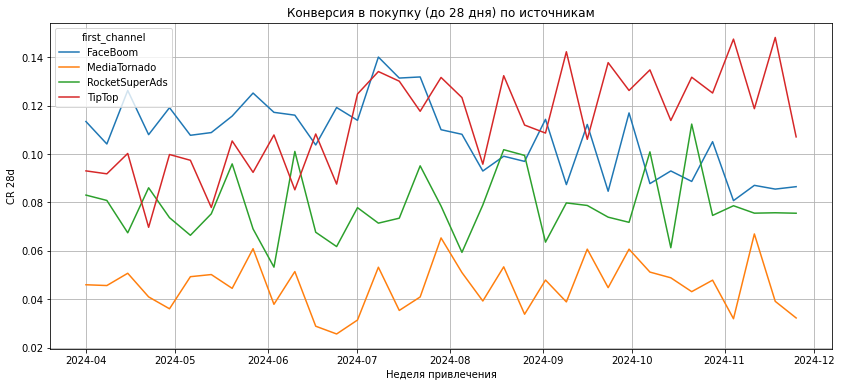

In [35]:
# Заказы до 28 дня
orders_28 = df_orders[df_orders['lifetime_day'] < 28]

# Флаг — сделал покупку до 28 дня
profiles['is_payer_28d'] = profiles['user_id'].isin(orders_28['user_id'].unique())

# Конверсия по недельным когортам
cr = profiles.groupby(['first_week', 'first_channel'])['is_payer_28d'] \
             .mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=cr, x='first_week', y='is_payer_28d', hue='first_channel')
plt.title('Конверсия в покупку (до 28 дня) по источникам')
plt.xlabel('Неделя привлечения')
plt.ylabel('CR 28d')
plt.grid(True)
plt.show()


Конверсия в покупку имеет более стабильную картину. Из канала MediaTornado реже всего пользователи доходят до этапа покупок, как с начала года, так и до конца, он имеет свои взлеты, но падения опускают его примерно до первоначального уровня в отметке 0.04. RocketSuperAdsимеет имеет сильные взлеты и падения, он может колебаться до 0.45 единиц, что довольно нестабильно, стоит тчательнее изучить этот канал, прежде чем вкладывать в него большие деньги, в среднем он достигает отметки в 0.08. FaceBoom изначально был лидером по покупкам, он твердо удерживал свои позиции на отметке в примерно 0.12, что является высоким результатом по сравнению с остальными каналами, однако после нововведений к середине июля он достигает своей пиковой отметки в 0.14, а потом с каждым месяцем падает все сильнее и сильнее, тем самым после своего яркого взлета к концу года он падает до отметки ниже начальной - 0.9, и начинает колебаться в разы сильнее, стоит явно обратить на это внимание, учитывая, что канал изначально держал довольно стабильную высокую отметку. TipTop с начала года был на втором месте по покупкам, однако после июня его значение начало резко расти, начав от 0.09, закончив 0.15, он не только обогнал предыдущего лидера - FaceBoom в июле, но и достиг самой максимально отметки по CR, однако с самого начала и до конча значения канала TipTop колебляться примерно на 0.2-0.3 единицы, тем самым делая его перспективным, но не стабильным

Посчитаем недельную динамику затрат на маркетинг по каждому источнику привлечения. 

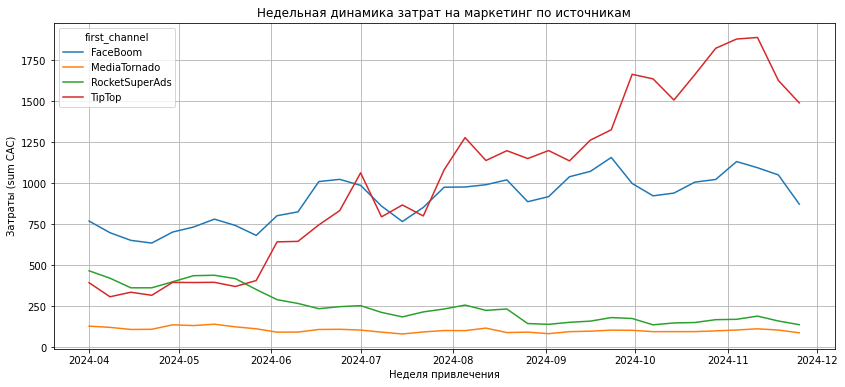

In [36]:
# Суммарные затраты за неделю по источникам
weekly_costs = profiles.groupby(['first_week', 'first_channel'])['cac'] \
                       .sum().reset_index(name='sum_costs')

plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_costs, x='first_week', y='sum_costs', hue='first_channel')
plt.title('Недельная динамика затрат на маркетинг по источникам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Затраты (sum CAC)')
plt.grid(True)
plt.show()


Картина становится яснее, компания приняла решение оставить затраты на маркетинг после нововведения примерно такими же, как и были, за исключением канала TipTop, скорее всего именно поэтому с июня месяца он сильно повысил свое влияние. Так же слегка урезался бюджет для RocketSuperAds, но всего на 250 единиц. Канал FaceBoom пополнился на теже 250 единиц

Посчитаем динамику среднего CAC.

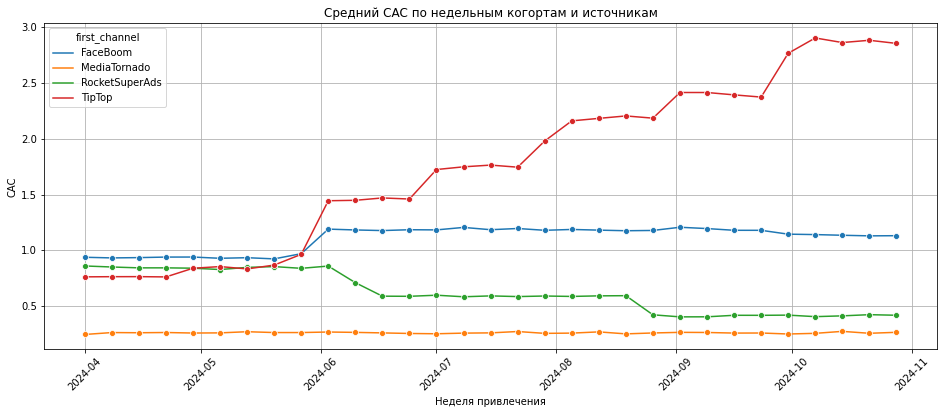

In [37]:
# Рассчитываем средний САС
cac_per_channel = profiles.copy()
cac_per_channel['interval'] = cac_per_channel['first_dt'].dt.to_period('W').dt.to_timestamp()
cac_per_channel = cac_per_channel.groupby(['first_channel','interval']).agg(
total_users = ('user_id','nunique'),
avg_cac = ('cac','mean'),
).reset_index()
# Оставляем покупки, совершенные в первые 28 дней
ltv_per_channel = df_orders[df_orders['lifetime_day'] < 28].copy()
# Выделяем первый месяц привлечения:
ltv_per_channel['interval'] = ltv_per_channel['first_dt'].dt.to_period('W').dt.to_timestamp()
# Считаем выручку с пользователей за каждый месяц (по месяцу привлечения)
ltv_per_channel = ltv_per_channel.groupby(['first_channel','interval']).agg(
revenue_28 = ('revenue','sum'),
).reset_index()
# Добавляем размер когорт и САС
ltv_per_channel = ltv_per_channel.merge(cac_per_channel, on=['first_channel','interval'])
# Считаем LTV на 28 день
ltv_per_channel['ltv_28'] = ltv_per_channel['revenue_28'] / ltv_per_channel['total_users']
# Рассчитаем ROI за 28 дней
ltv_per_channel['roi_28'] = (ltv_per_channel['ltv_28'] - ltv_per_channel['avg_cac']) / ltv_per_channel['avg_cac']

ltv_filtered = ltv_per_channel[ltv_per_channel['interval'] < '2024-11-01']

plt.figure(figsize=(16, 6))
sns.lineplot(data=ltv_filtered, x='interval', y='avg_cac', hue='first_channel', marker='o')
plt.title('Средний CAC по недельным когортам и источникам')
plt.xlabel('Неделя привлечения')
plt.ylabel('CAC')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Данные имеют практически такое же значение, как и предыдущий график, после новой фишки сильнее всего финансово  вкладывались в TipTop, слабее в FaceBoom, хуже в RocketSuperAds. В канале MediaTornado ничего не изменилось

Посчитаем динамику LTV.

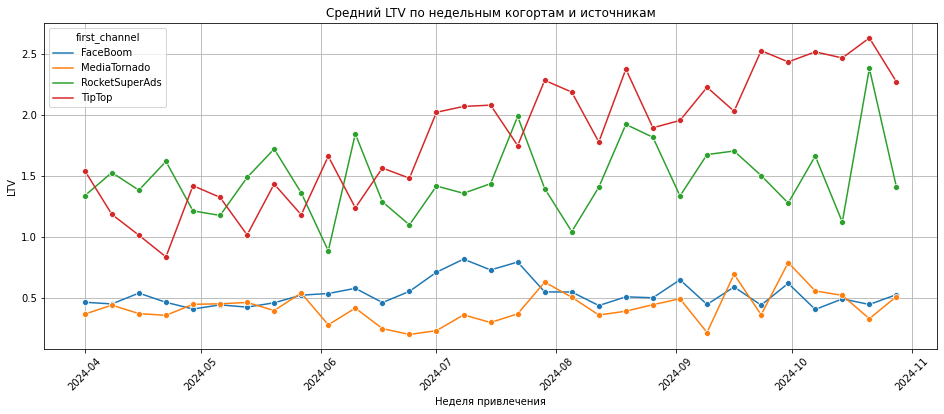

In [38]:
# LTV
plt.figure(figsize=(16, 6))
sns.lineplot(data=ltv_filtered, x='interval', y='ltv_28', hue='first_channel', marker='o')
plt.title('Средний LTV по недельным когортам и источникам')
plt.xlabel('Неделя привлечения')
plt.ylabel('LTV')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Данные показывают, что с самого начала в среднем больше всего прибыли приносил каналы RocketSuperAds и TipTop, они начина с отметки примерно 1.5. При этом TipTop в дальнейшем показывал себя чуть хуже, чаще занимая второе место, однако с конца июня он становится безоговорочным лидером, достигая своего пика в отметке 2.6. Однако RocketSuperAds тоже не переставал рости, практически дублируя показатели TipTop, но отставая на 0.5-1 единицу, это хороший результат, учитывая, что ему, в отличие от TipTop урезали бюджет, но также бросаются в глаза его резкие падения, которые в разы ниже, чем у TipTop. FaceBoom и MediaTornado показывают довольно низкие результаты, они от начала и до конца держаться примерно в отметке 0.5, учитывая, что FaceBoom увеличили бюджет, в очередной раз доказывая, что он лишь хорошо заинтересовывает пользователей попробовать использовать приложение, но не совершать покупки

Посчитаем динамику ROI.

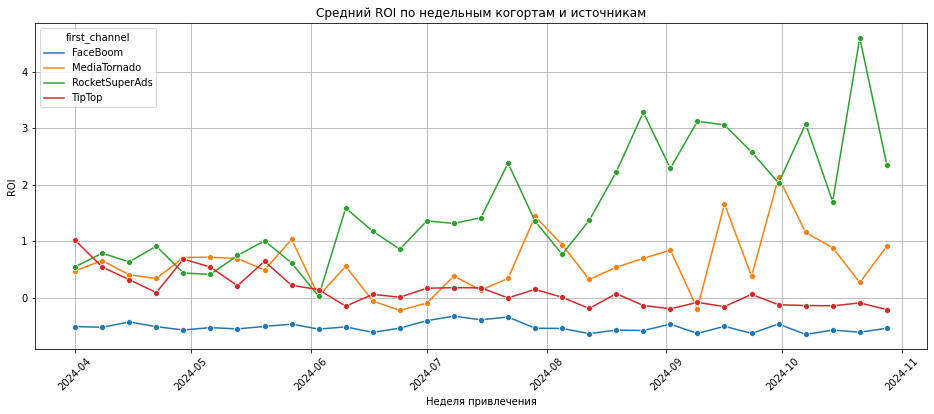

In [39]:
# ROI
plt.figure(figsize=(16, 6))
sns.lineplot(data=ltv_filtered, x='interval', y='roi_28', hue='first_channel', marker='o')
plt.title('Средний ROI по недельным когортам и источникам')
plt.xlabel('Неделя привлечения')
plt.ylabel('ROI')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Средний ROI показвает печальную картину, TipTop и FaceBoom не окупаю потраченные на них вложения в июне, при условии, что это единственные каналы, в которых вкладывались дополнительно, они занимают самые низкие позиции, а после ноября имеют практически одинаковой низкое значение - ниже 0, хотя, при этом с сначала года ни один из этих каналов не показывал активного роста, а FaceBoom изначаль находился в отметке ниже 0, а TipTop в ноябре начинал с отметки такой же, как и остальные 2 канала- это около 1. RocketSuperAds же тоже начинает с отметки около 1, но опустившись к июню до отметки в 0, с июня показывает сильную активность инвестиций, обгоняя всех, имеет также ярко выраженные падения, но к ноябрю достигает своего пика в отметке выше 4. MediaTornado тоже начинал с отметки  около 1, но к октябрю поднялся до 2, это хороший результат, учитывая, что в него изначально плохо вкладывались, стабильный канал, без ярких взлетов и падений

FaceBoom — лидер по числу привлечённых пользователей (28 401), DAU и MAU стабильно высокие, однако удержание пользователей низкое, скользящее удержание на 14–28 день около 0.03. LTV канал приносит мало выручки (0.5), ROI после нововведений остается также критичным. Канал эффективен для быстрого привлечения аудитории, но плохо удерживает и окупается медленно, LTV низкий, поэтому вложения не окупаются в короткий срок.

TipTop — демонстрирует значительный рост после внедрения нового контента: число новых пользователей, DAU и MAU растут активно, удержание высокое (до 0.3), LTV очень высокий (2.5), ROI низкий, к кончу года в отметке ниже 0. Перспективный канал с долгосрочными пользователями, требующий контроля над расходами и мониторинга ROI. Не окупился из-за роста числа пользователей и затрат на маркетинг после нововведений, в первые недели ROI не успел компенсировать расходы.

RocketSuperAds — привлекает умеренное количество пользователей, DAU и MAU стабильны, удержание на среднем уровне (0.13), LTV высокий (2.4), ROI самый высокий (4.5). Канал эффективно генерирует выручку, несмотря на сокращение маркетингового бюджета. 

MediaTornado — канал с наименьшей конверсией в покупки, DAU и MAU умеренные, удержание стабильное, LTV - 0.5, ROI средний (1). Канал не растёт активно и окупаемость медленная, инвестиции требуют оптимизации. Канал стабильно привлекает пользователей, но они редко совершают покупки,хотя в целом можно сказать, что расходы окупились.

Выводы:

Каналы FaceBoom и TipTop ключевые для роста пользовательской базы, но FaceBoom требует улучшения удержания, а TipTop — контроля над ROI.

RocketSuperAds приносит стабильную выручку при умеренных вложениях.

MediaTornado медленный и хорошо окупается за короткий период.

## Анализ периода окупаемости маркетинговых вложений

Для источников, которые к 28-му дню не выходят на уровень окупаемости, рассчитаем и визуализируем в виде тепловой карты значения ROI за больший период, например за 8–10 недель.


Рассмотрим подробнее каналы FaceBoom и TipTop.

Подготовим данные, рассчитаем ROI. 

In [40]:
# Берем все покупки
pp = df_orders.copy()

# Выделяем первую неделю привлечения
pp['first_week'] = pp['first_dt'].dt.to_period('W').dt.to_timestamp()

# Выделяем неделю покупки
pp['week'] = pp['event_dt'].dt.to_period('W').dt.to_timestamp()

# Рассчитаем разницу между минимальной датой и текущей датой в неделях
pp['N_week'] = (pp['week'] - pp['first_week']).dt.days / 7

# Суммируем revenue для каждой недели
pp = pp.groupby(['first_channel', 'first_week', 'N_week'])['revenue'].sum().reset_index()

# Отсортируем данные по N_week, для корректного расчета LTV при помощи cumsum()
pp = pp.sort_values(by=['first_channel', 'N_week'])

# Посчитаем кумулятивную выручку для каждой недели
pp['cum_revenue'] = pp.groupby(['first_channel','first_week'])['revenue'].cumsum()

# Считаем размер когорт
w_channel_cohort_size = profiles.copy()
w_channel_cohort_size['first_week'] = w_channel_cohort_size['first_dt'].dt.to_period('W').dt.to_timestamp()

w_channel_cohort_size = w_channel_cohort_size.groupby(['first_channel','first_week']).agg({'user_id':'nunique','cac':'mean'}).reset_index()
w_channel_cohort_size.columns = ['first_channel', 'first_week', 'total_users', 'cac']

# Добавим размер когорт и стоимость одного пользователя
pp = pp.merge(w_channel_cohort_size, on=['first_channel','first_week'])
pp['ltv'] = pp['cum_revenue'] / pp['total_users']

# Считаем ROI
pp['roi'] = (pp['ltv'] - pp['cac']) / pp['cac']



Визуализируем FaceBoom

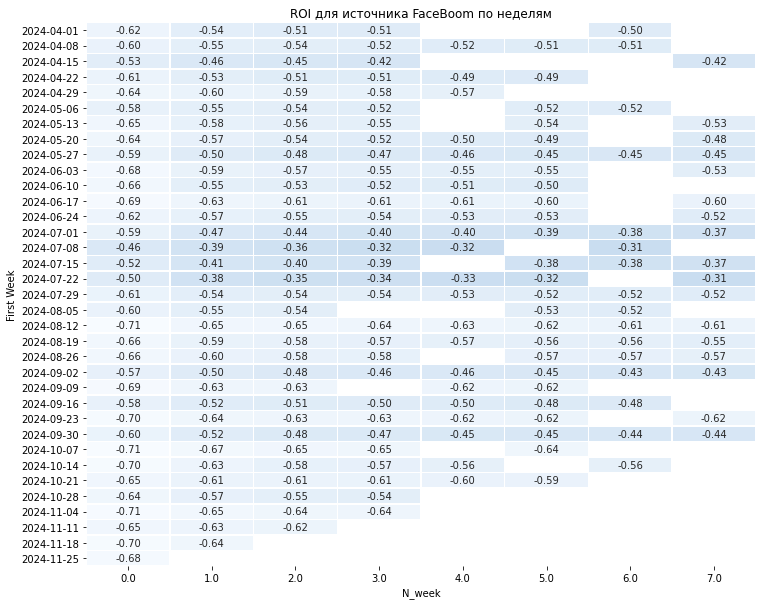

In [41]:
# Строим карту для FaceBoom
tiptop = pp.query('first_channel == "FaceBoom"').query('N_week < 7')

# Пивотируем данные, чтобы first_week были индексами, а N_week - столбцами
tiptop_pp = tiptop.pivot(index='first_week', columns='N_week', values='roi')
tiptop_pp.index = np.datetime_as_string(tiptop_pp.index, unit='D')

# Строим heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(tiptop_pp,
        annot=True,
        fmt='.2f',
        linewidths=0.5, linecolor='white',
        vmax=1, cmap='Blues',
        cbar=False)

plt.title('ROI для источника FaceBoom по неделям')
plt.xlabel('N_week')
plt.ylabel('First Week')
plt.show()

Можно с уверенностью говорить, что FaceBoom никогда себя не окупал. Причем благодаря нововведениям в июне были моменты, что окупался даже хуже, чем в начале. Если в ноябрьской когорте  на 8 неделю значения достигали - 0.42, то после июня появлись значения -0.62. Однозначно не стоило вкладываться сильнее в этот канал

Визуализируем TipTop

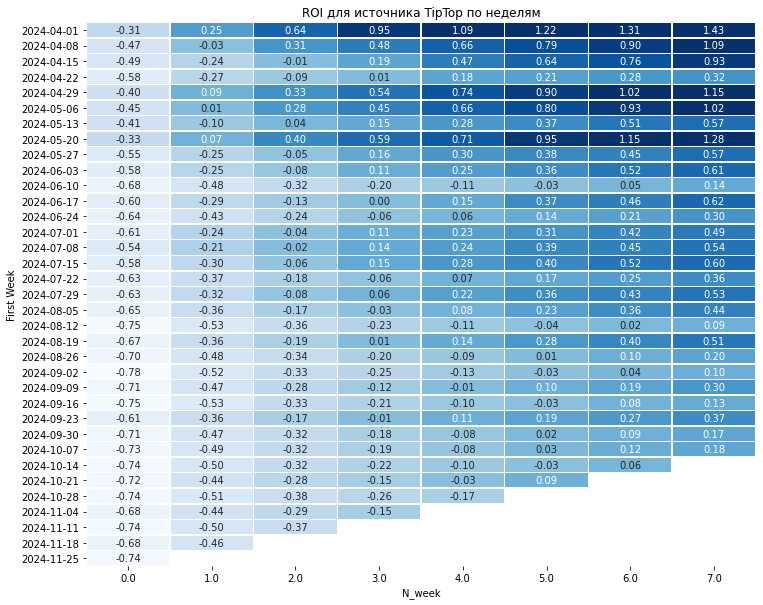

In [42]:
# Строим карту для FaceBoom
tiptop = pp.query('first_channel == "TipTop"').query('N_week < 8')

# Пивотируем данные, чтобы first_week были индексами, а N_week - столбцами
tiptop_pp = tiptop.pivot(index='first_week', columns='N_week', values='roi')
tiptop_pp.index = np.datetime_as_string(tiptop_pp.index, unit='D')

# Строим heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(tiptop_pp,
        annot=True,
        fmt='.2f',
        linewidths=0.5, linecolor='white',
        vmax=1, cmap='Blues',
        cbar=False)

plt.title('ROI для источника TipTop по неделям')
plt.xlabel('N_week')
plt.ylabel('First Week')
plt.show()

С TipTop дела обстоят намного лучше, в начале года он всегда окупался ко 2- 3 неделе, а в конце периода чаще всего достигал отметок выше 1. с увеличением маркетинга июльские когорты стали окупаться дольше в промежутке с 3 по 5 недели, а к 8 неделе имел отметку в среднем в 0.3, то есть окупаемость понизилась примерно в 3 раза

FaceBoom никогда не окупался, а после июня ROI по 8-й неделе упал до -0.62, дополнительные вложения были неоправданны. TipTop остаётся перспективным, хотя с увеличением маркетинга окупаемость замедлилась до 0.3 к 8-й неделе.

## Выводы и рекомендации




После анализа приложения Procrastinate Pro+ можно сделать несколько ключевых выводов. 
- Аудитория приложения растёт,  DAU и MAU показывают устойчивый восходящий тренд с начала апреля по ноябрь, при этом Stickiness слегка увеличивается, подтверждая, что пользователи постепенно привыкают к приложению и возвращаются регулярно. 
- Введение нового спортивного контента в начале лета привлекло дополнительную аудиторию, что заметно по росту DAU и MAU у канала TipTop, однако краткосрочно вызвало падение удержания в мае–июне, вероятно из-за адаптации пользователей к новому формату. 
- Канал FaceBoom стабильно привлекает большое количество пользователей, но удержание низкое, а ROI никогда не достигал окупаемости и после июня ухудшился, поэтому дополнительные вложения в этот канал неэффективны. TipTop демонстрирует значительный рост числа пользователей и высокое удержание, однако с увеличением маркетинговых вложений окупаемость новых когорт замедляется, а ROI к 8-й неделе снижается примерно в 3 раза, что связано с высокой стоимостью привлечения и относительно медленным приростом LTV. Каналы RocketSuperAds и MediaTornado показывают стабильное привлечение и удержание, окупаются быстрее и демонстрируют средний уровень ROI, что делает их надёжными и россматриваемыми для вложения инвестиций.
- Маркетинговые расходы распределены неравномерно: значительные вложения приходятся на TipTop и FaceBoom, что не всегда оправдано, учитывая стабильную прибыльность RocketSuperAds. 

Рекомендации: 
- перераспределить часть бюджета с TipTop на более стабильные каналы, например рассмотреть RocketSuperAds
- TipTop показывает медленную окупаемость, стоит исследовать, почему пользователи теряются, и улучшить и вовлеченность.
- улучшить удержание пользователей FaceBoom, например через персонализированные уведомления или  бонусы, ведь именно от него больше всего приходят новые пользователи
- запускать спортивный контент с бонусными или акциями для первых пользователей, стимулируя ранние покупки и ускоряя окупаемость
- разобраться, какой тип контента наиболее сильно повышает "прилипательность", и направлять маркетинговые кампании на привлечение именно таких пользователей.